In [28]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')
plt.rcParams.update({'font.size': 12})

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.naive_bayes import MultinomialNB

import pickle

from mongo_client import mongo_client

In [2]:
db = mongo_client.get_database('historical_events')
collection = db.get_collection('event_descriptions')

In [3]:
stop_words = list(ENGLISH_STOP_WORDS) + [
    'abc', 'ampndash', 'ampamp', 'amp', 'ampampndash', 'ampquot', 'ampquotthe', 'ampref',
    'http', 'href', 'html', 'htm', 'www', 'com'
]
count_vectorizer = CountVectorizer(ngram_range=(1,2), min_df=2, max_df=0.9,
                                   stop_words=stop_words, token_pattern="\\b[a-z][a-z]+\\b")
mdocs = [mdoc for mdoc in collection.find()]
docs = [mdoc['description'].split('{{')[0] for mdoc in mdocs]
count_vectorizer.fit(docs)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9, max_features=None, min_df=2,
        ngram_range=(1, 2), preprocessor=None,
        stop_words=['put', 'anyhow', 'eleven', 'inc', 'whole', 'himself', 'herein', 'out', 'bill', 'it', 'my', 'amount', 'below', 'on', 'first', 'something', 'whereafter', 'both', 'have', 'ltd', 'being', 'of', 'although', 'during', 'either', 'front', 'somehow', 'name', 'about', 'elsewhere', 'may', 'one', 'w...amp', 'ampampndash', 'ampquot', 'ampquotthe', 'ampref', 'http', 'href', 'html', 'htm', 'www', 'com'],
        strip_accents=None, token_pattern='\\b[a-z][a-z]+\\b',
        tokenizer=None, vocabulary=None)

In [4]:
X = count_vectorizer.transform(docs)
y = [int(mdoc['year'] / 10) * 10 for mdoc in mdocs]
(X[0], y[0])

(<1x36496 sparse matrix of type '<class 'numpy.int64'>'
 	with 8 stored elements in Compressed Sparse Row format>, 1900)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
clf = MultinomialNB()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.2935764469722315

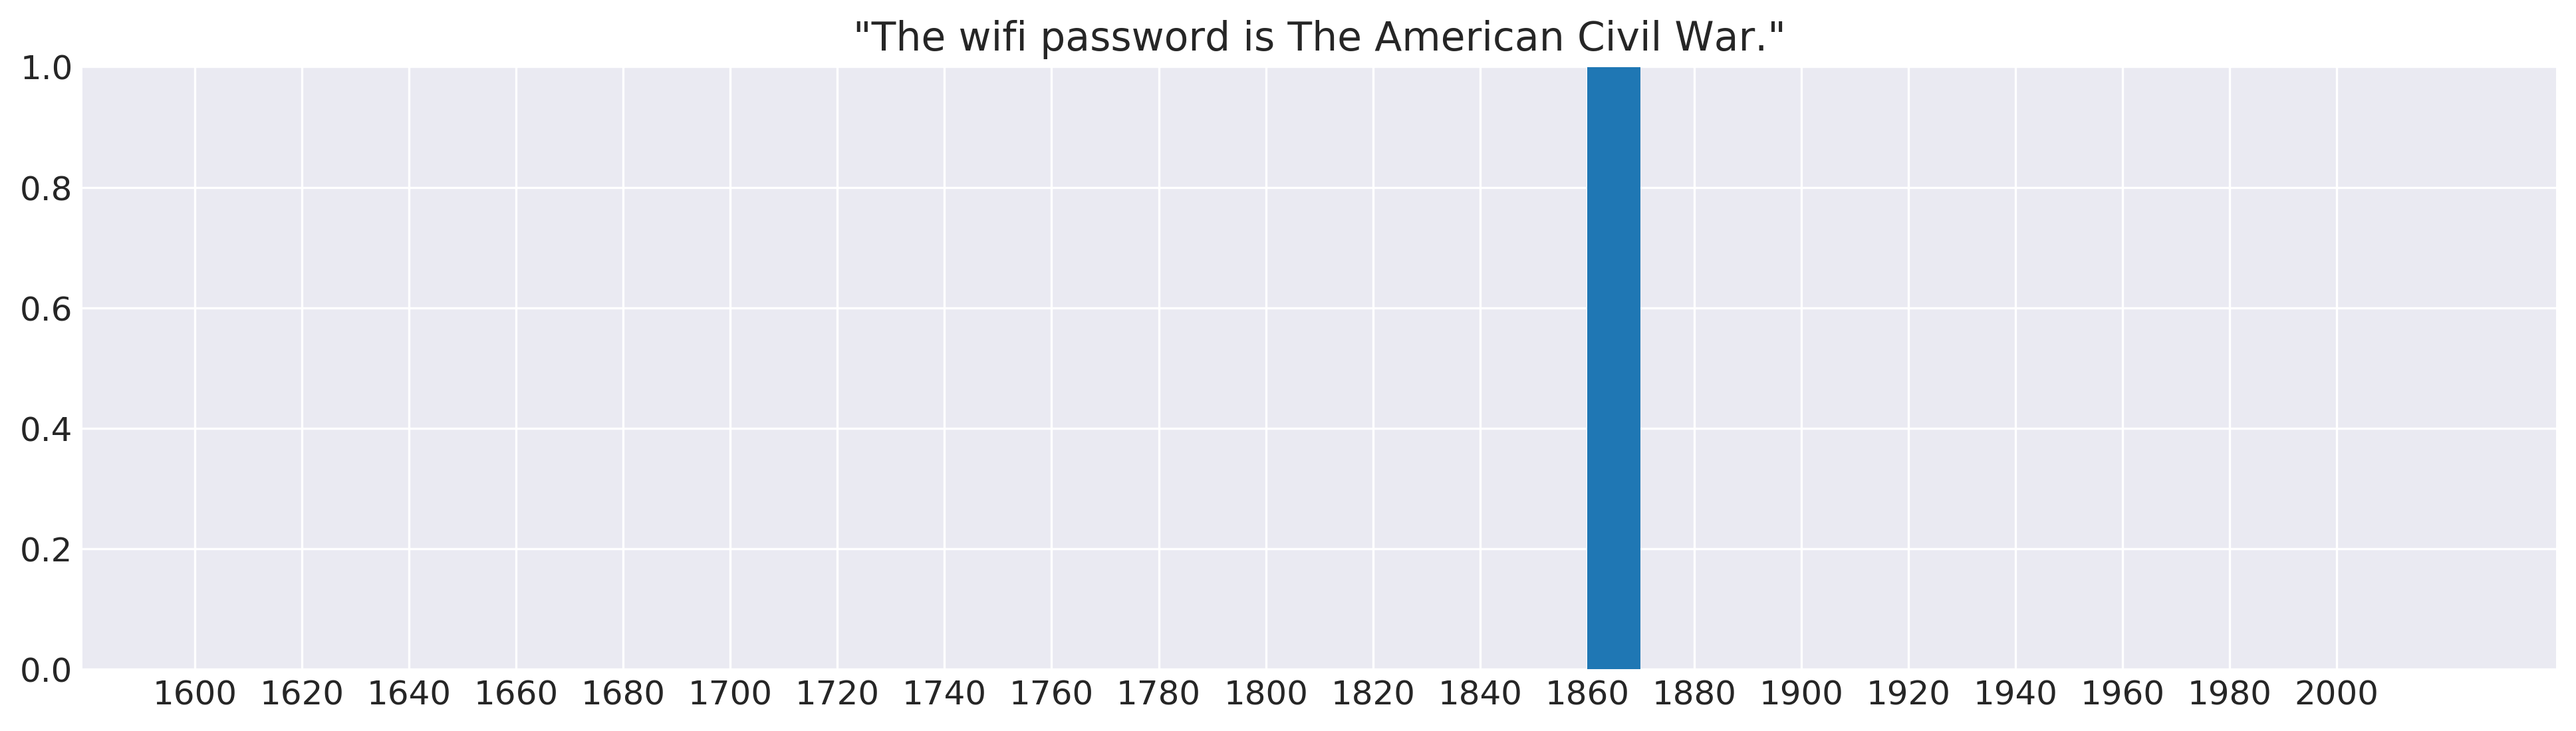

In [51]:
def generate_prediction_graph(sentence):
    pred = clf.predict_proba(count_vectorizer.transform([sentence]))[0]
    plt.figure(figsize=(16, 4), dpi=300)
    plt.title('"{}"'.format(sentence))
    plt.ylim((0, 1))
    decades = range(1600, 1600 + 10 * len(pred), 10)
    plt.xticks([d for d in decades if ((d / 10) + 1) % 2])
    plt.bar(decades, pred, width=10, align='edge');
    
# generate_prediction_graph('Harry Potter wins the Nebraska State Lottery!')
# generate_prediction_graph('Napoleon realizes he is French.')
# generate_prediction_graph('Honk beep.')
# generate_prediction_graph('King James V signs a treaty.')
generate_prediction_graph('The wifi password is The American Civil War.')

In [20]:
nb_model_components = {
    'count_vectorizer': count_vectorizer,
    'clf': clf
}


with open('nb_model_components.pkl', 'wb') as file:
    pickle.dump(nb_model_components, file)

In [34]:
list(collection.find({'year': 1648}))[-10:]

[{'_id': ObjectId('5b0f0dcb8384e30063f8bb68'),
  'date': '1648/08/12',
  'description': ' Mehmed IV (1648–1687) succeeds Ibrahim I (1640–1648) as Ottoman Emperor.',
  'lang': 'en',
  'category1': 'July&amp;amp;amp;ndash;December',
  'granularity': 'year',
  'year': 1648},
 {'_id': ObjectId('5b0f0dcb8384e30063f8bb69'),
  'date': '1648/09/12',
  'description': ' Battle of Stirling takes place in Scotland: quotEngagersquot achieve victory over the Kirk Party.',
  'lang': 'en',
  'category1': 'July&amp;amp;amp;ndash;December',
  'granularity': 'year',
  'year': 1648},
 {'_id': ObjectId('5b0f0dcb8384e30063f8bb6a'),
  'date': '1648/10/24',
  'description': " Signing of the Treaties of Münster and Osnabrück conclude the Peace of Westphalia, ending the Thirty Years' War. Rulers of the Imperial States have powers to decide their state religion, Protestant, Catholic or Calvinist, with the minorities of each of those faiths granted toleration of worship, and there is general recognition of exclus